<a href="https://colab.research.google.com/github/jibitesh2004/jibitesh2004/blob/main/Predict_rocket_launch_delays_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT LIBRARIES

In [66]:
import pandas as pd
import numpy as np
import requests  # For API calls

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import pydotplus
from IPython.display import display, clear_output, Image

import ipywidgets as widgets

# For voice output using gTTS
!pip install gTTS
from gtts import gTTS
from IPython.display import Audio

# For reproducibility
np.random.seed(42)

# **Load Historical Excel Data (Past Data)**


In [67]:
try:
    launch_data = pd.read_excel('Generated.xlsx')
    launch_data.columns = [col.strip() for col in launch_data.columns]  # Remove spaces from column names
    print("Excel data loaded successfully.")
except Exception:
    print("Error loading Excel file. Using synthetic historical data for demo.")
    launch_data = pd.DataFrame({
        'Name': ['Rocket A'] * 10,
        'Date': pd.date_range(start='2025-01-01', periods=10),
        'Time (East Coast)': ['10:00 AM'] * 10,
        'Location': ['Cape Canaveral'] * 10,
        'Crewed or Uncrewed': np.random.choice(['Crewed', 'Uncrewed'], 10),
        'Launched?': np.random.choice(['Y', 'N'], 10),
        'Wind Direction': np.random.choice(['N', 'S', 'E', 'W'], 10),
        'Condition': np.random.choice(['Fair', 'Cloudy', 'Stormy'], 10)
    })

# Fill missing values
launch_data.fillna({'Launched?': 'N', 'Crewed or Uncrewed': 'Uncrewed', 'Wind Direction': 'unknown', 'Condition': 'Fair'}, inplace=True)

# Generate synthetic delay times
launch_data['DelayTime'] = np.random.uniform(10, 60, launch_data.shape[0])

# Add extra numerical features
launch_data['Temperature'] = np.random.uniform(15, 35, launch_data.shape[0])  # In °C
launch_data['WindSpeed'] = np.random.uniform(0, 50, launch_data.shape[0])  # In km/h
launch_data['Precipitation'] = np.random.uniform(0, 5, launch_data.shape[0])  # mm
launch_data['SensorReading'] = np.random.uniform(0.8, 1.0, launch_data.shape[0])  # Simulated sensor data
launch_data['CommLog'] = np.random.choice([
    "All systems nominal, ready for launch.",
    "Minor issues detected in fuel sensors, proceed with caution.",
    "Crew on standby, monitoring weather.",
    "Unexpected alert in telemetry data, investigate further."
], launch_data.shape[0])

# ========================
# STEP 3: Define Features & Target for Training
# ========================
y = launch_data['DelayTime']
cols_to_drop = ['Name', 'Date', 'Time (East Coast)', 'Location', 'Launched?', 'DelayTime']
X = launch_data.drop(columns=cols_to_drop)

# Encode categorical features
label_encoder = LabelEncoder()
for col in ['Crewed or Uncrewed', 'Wind Direction', 'Condition']:
    X[col] = label_encoder.fit_transform(X[col])


Excel data loaded successfully.


# **Clean & Process Historical Data**

In [68]:
numeric_pipeline = Pipeline([('scaler', StandardScaler())])
text_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=50))])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, ['Temperature', 'WindSpeed', 'Precipitation', 'SensorReading']),
    ('text', text_pipeline, 'CommLog')
])
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=0, max_depth=5))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
model_pipeline.fit(X_train, y_train)
print(f"\nModel trained successfully. R² Score on test data: {model_pipeline.score(X_test, y_test):.2f}")



Model trained successfully. R² Score on test data: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# **Enrich Historical Data with Additional Features**

In [69]:
if 'Temperature' not in launch_data.columns:
    launch_data['Temperature'] = np.random.uniform(60, 90, launch_data.shape[0])
if 'WindSpeed' not in launch_data.columns:
    launch_data['WindSpeed'] = np.random.uniform(0, 50, launch_data.shape[0])
if 'Precipitation' not in launch_data.columns:
    launch_data['Precipitation'] = np.random.uniform(0, 5, launch_data.shape[0])
if 'SensorReading' not in launch_data.columns:
    launch_data['SensorReading'] = np.random.uniform(0.8, 1.0, launch_data.shape[0])
if 'CommLog' not in launch_data.columns:
    launch_data['CommLog'] = np.random.choice([
        "All systems nominal, ready for launch.",
        "Minor issues detected in fuel sensors, proceed with caution.",
        "Crew on standby, monitoring weather.",
        "Unexpected alert in telemetry data, investigate further."
    ], launch_data.shape[0])

# **Define Features & Target for Training**

In [70]:
y = launch_data['DelayTime']
cols_to_drop = ['Name', 'Date', 'Time (East Coast)', 'Location', 'Launched?', 'DelayTime']
X = launch_data.drop(columns=cols_to_drop)

print("Training features:", X.columns.tolist())

numeric_features = ['Temperature', 'WindSpeed', 'Precipitation', 'SensorReading',
                    'Crewed or Uncrewed', 'Wind Direction', 'Condition']
text_feature = 'CommLog'

Training features: ['Crewed or Uncrewed', 'High Temp', 'Low Temp', 'Ave Temp', 'Temp at Launch Time', 'Hist High Temp', 'Hist Low Temp', 'Hist Ave Temp', 'Percipitation at Launch Time', 'Hist Ave Percipitation', 'Wind Direction', 'Max Wind Speed', 'Visibility', 'Wind Speed at Launch Time', 'Hist Ave Max Wind Speed', 'Hist Ave Visibility', 'Sea Level Pressure', 'Hist Ave Sea Level Pressure', 'Day Length', 'Condition', 'Notes', 'Temperature', 'WindSpeed', 'Precipitation', 'SensorReading', 'CommLog']


# **Encode Categorical Data for Training**

In [71]:
label_encoder = LabelEncoder()
for col in ['Crewed or Uncrewed', 'Wind Direction', 'Condition']:
    if X[col].dtype == 'object':
        X[col] = label_encoder.fit_transform(X[col])


# **Build a Multimodal Pipeline (Regression)**

In [72]:
numeric_pipeline = Pipeline([('scaler', StandardScaler())])
text_pipeline = Pipeline([('tfidf', TfidfVectorizer(max_features=50))])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('text', text_pipeline, text_feature)
])
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=0, max_depth=5))
])

# **Train the Model**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
model_pipeline.fit(X_train, y_train)
r2_score = model_pipeline.score(X_test, y_test)
print(f"\nModel R² Score on Historical Test Data: {r2_score:.2f}")




Model R² Score on Historical Test Data: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


# **Visualize the Decision Tree**

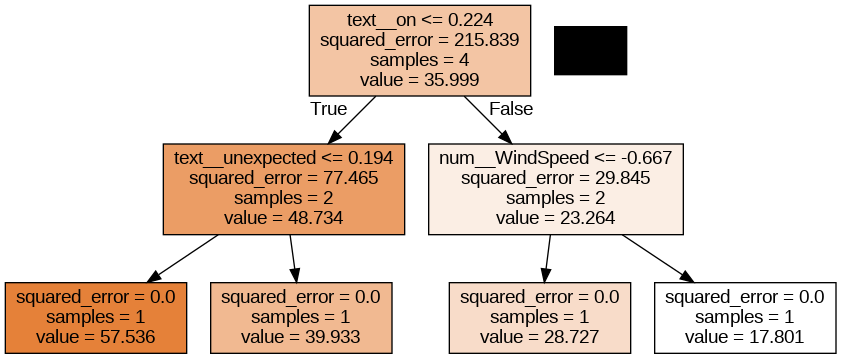

In [74]:
def tree_graph_to_png(tree_model, feature_names):
    tree_str = export_graphviz(tree_model,
                               feature_names=feature_names,
                               filled=True,
                               out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    return Image(graph.create_png())

feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
decision_tree = model_pipeline.named_steps['regressor']
tree_image = tree_graph_to_png(decision_tree, feature_names=feature_names)
display(tree_image)

# **Live Data Functions Using Open-Meteo API & Simulated Space Condition**

In [75]:
def fetch_live_weather(city="Cape Canaveral"):
    """
    Fetch live weather data using the Open-Meteo API.
    For Cape Canaveral, we use its latitude and longitude.
    Open-Meteo is free and requires no API key.
    """
    latitude = 28.3922
    longitude = -80.6077
    url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        current_weather = data.get("current_weather", {})
        temperature = current_weather.get("temperature", None)  # in Celsius
        if temperature is not None:
            temperature = temperature * 9/5 + 32  # Convert to Fahrenheit
        wind_speed = current_weather.get("windspeed", None)  # in km/h
        if wind_speed is not None:
            wind_speed = wind_speed / 1.609  # Convert to mph
        precipitation = 0  # Not provided by current_weather
        return temperature, wind_speed, precipitation
    else:
        return np.random.uniform(60, 90), np.random.uniform(0, 50), np.random.uniform(0, 5)

def simulate_live_space_condition():
    """
    Simulate live space condition based on an internal algorithm.
    For this demo, we'll simply randomly choose a condition.
    In a real system, this could come from fast internal sensors or anomaly detection.
    """
    conditions = ["Calm", "Moderate", "Disturbed"]
    return np.random.choice(conditions)

def generate_sensor_alert(sensor_value, threshold=0.9):
    """
    Auto-generate an alert based on the sensor reading and live space condition.
    If sensor_value is below threshold, generate an immediate alert.
    Additionally, append the simulated live space condition.
    """
    alert_message = ""
    if sensor_value < threshold:
        alert_message += "Alert: Fuel pump sensor reading is below normal. Check required. "
    else:
        alert_message += "Fuel pump sensor operating normally. "

    space_condition = simulate_live_space_condition()
    alert_message += f"Live space condition is {space_condition}."
    return alert_message


Can you predict whether a launch is likely to happen given specific weather conditions?

# **Sample Live Input Prediction with Live Data, Explanation, & Voice Output**

In [76]:

# Manual mappings for categorical features.
crew_mapping = {'Crewed': 0, 'Uncrewed': 1}
wind_mapping = {'N': 0, 'S': 1, 'E': 2, 'W': 3, 'unknown': 4}
condition_mapping = {'Fair': 0, 'Cloudy': 1, 'Stormy': 2}

# Fetch live weather data using Open-Meteo API.
live_temp, live_wind, live_precip = fetch_live_weather()
# Simulate a live sensor reading (set below threshold to trigger alert).
live_sensor = 0.85  # below threshold 0.9 triggers alert.
# Auto-generate live alert message using sensor reading and simulated space condition.
live_comm = generate_sensor_alert(live_sensor)

# Prepare a sample live input.
sample_input = {
    'Temperature': live_temp,
    'WindSpeed': live_wind,
    'Precipitation': live_precip,
    'SensorReading': live_sensor,
    'Crewed or Uncrewed': crew_mapping['Crewed'],
    'Wind Direction': wind_mapping['N'],
    'Condition': condition_mapping['Fair'],
    'CommLog': live_comm
}
sample_df = pd.DataFrame([sample_input])
print("\nLive Sample Input for Prediction:")
print(sample_df)

# Predict delay time (in minutes)
predicted_delay_minutes = model_pipeline.predict(sample_df)[0]
predicted_delay_seconds = predicted_delay_minutes * 60
predicted_delay_hours = predicted_delay_minutes / 60
print(f"\nPredicted Delay Time: {predicted_delay_minutes:.1f} minutes "
      f"({predicted_delay_seconds:.0f} seconds, {predicted_delay_hours:.2f} hours)")

def generate_delay_statement(input_data, delay_minutes):
    reasons = []
    if input_data['WindSpeed'] > 30:
        reasons.append("high wind speeds")
    if input_data['Precipitation'] > 2:
        reasons.append("heavy precipitation")
    if input_data['SensorReading'] < 0.9:
        reasons.append("suboptimal sensor readings")
    keywords = ['alert', 'check required']
    if any(keyword in input_data['CommLog'].lower() for keyword in keywords):
        reasons.append("live sensor alert indicating potential issues")
    if not reasons:
        reasons.append("all parameters nominal")
    statement = (f"The rocket launch is predicted to be delayed by {delay_minutes:.1f} minutes "
                 f"({delay_minutes*60:.0f} seconds, {delay_minutes/60:.2f} hours) due to "
                 + ", ".join(reasons) + ".")
    return statement

explanation = generate_delay_statement(sample_input, predicted_delay_minutes)
print("\nExplanation:")
print(explanation)



Live Sample Input for Prediction:
   Temperature  WindSpeed  Precipitation  SensorReading  Crewed or Uncrewed  \
0        82.94  17.588564              0           0.85                   0   

   Wind Direction  Condition  \
0               0          0   

                                             CommLog  
0  Alert: Fuel pump sensor reading is below norma...  

Predicted Delay Time: 57.5 minutes (3452 seconds, 0.96 hours)

Explanation:
The rocket launch is predicted to be delayed by 57.5 minutes (3452 seconds, 0.96 hours) due to suboptimal sensor readings, live sensor alert indicating potential issues.


# **Interactive Demo with Live Data Fetching (No Manual Unstructured Input)**

In [77]:
print("\nInteractive Demo:")

# Create interactive sliders for live structured data.
temp_slider = widgets.FloatSlider(min=50, max=100, step=0.5, description='Temperature:', value=live_temp)
wind_slider = widgets.FloatSlider(min=0, max=50, step=0.5, description='Wind Speed:', value=live_wind)
precip_slider = widgets.FloatSlider(min=0, max=10, step=0.1, description='Precipitation:', value=live_precip)
sensor_slider = widgets.FloatSlider(min=0.8, max=1.0, step=0.01, description='Sensor Reading:', value=live_sensor)

# Button to fetch live weather data using Open-Meteo API.
def fetch_live_data(b):
    new_temp, new_wind, new_precip = fetch_live_weather()
    temp_slider.value = new_temp
    wind_slider.value = new_wind
    precip_slider.value = new_precip
    sensor_slider.value = np.random.uniform(0.8, 1.0)  # Simulate a new sensor reading.

fetch_live_button = widgets.Button(description="Fetch Live Weather Data")
fetch_live_button.on_click(fetch_live_data)

# Output widget for interactive prediction.
interactive_output = widgets.Output()

def interactive_predict(change=None):
    auto_comm = generate_sensor_alert(sensor_slider.value)
    input_df = pd.DataFrame({
        'Temperature': [temp_slider.value],
        'WindSpeed': [wind_slider.value],
        'Precipitation': [precip_slider.value],
        'SensorReading': [sensor_slider.value],
        'Crewed or Uncrewed': [crew_mapping['Crewed']],
        'Wind Direction': [wind_mapping['N']],
        'Condition': [condition_mapping['Fair']],
        'CommLog': [auto_comm]
    })
    pred = model_pipeline.predict(input_df)[0]
    explanation_text = generate_delay_statement(input_df.iloc[0].to_dict(), pred)
    with interactive_output:
        clear_output(wait=True)
        print(f"Interactive Prediction: {pred:.1f} minutes delay "
              f"({pred*60:.0f} seconds, {pred/60:.2f} hours)")
        print("Explanation:", explanation_text)
        tts_interactive = gTTS(text=explanation_text, lang='en')
        tts_interactive.save("interactive_explanation.mp3")
        display(Audio("interactive_explanation.mp3", autoplay=True))

temp_slider.observe(interactive_predict, names='value')
wind_slider.observe(interactive_predict, names='value')
precip_slider.observe(interactive_predict, names='value')
sensor_slider.observe(interactive_predict, names='value')

display(fetch_live_button, temp_slider, wind_slider, precip_slider, sensor_slider, interactive_output)
interactive_predict()  # Initial prediction


Interactive Demo:


Button(description='Fetch Live Weather Data', style=ButtonStyle())

FloatSlider(value=82.94, description='Temperature:', min=50.0, step=0.5)

FloatSlider(value=17.588564325668116, description='Wind Speed:', max=50.0, step=0.5)

FloatSlider(value=0.0, description='Precipitation:', max=10.0)

FloatSlider(value=0.85, description='Sensor Reading:', max=1.0, min=0.8, step=0.01)

Output()